In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import pybaseball as pb

In [4]:
# Read in the 2022 data, use this for training
datas = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")

In [5]:
#use this for predictions
df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/deltaRE_og_description.csv")

In [6]:
model_data = datas.loc[(datas['description'] == 'called_strike') | (datas['description'] == 'ball')].copy() # only called strikes and balls
df = df.loc[(df['description'] == 'called_strike') | (df['description'] == 'ball')].copy() # only called strikes and balls

In [7]:
model_data['is_strike'] = model_data['description'].map({'called_strike': 1, 'ball': 0}) # convert to binary
model_data['p_throws'] = model_data['p_throws'].map({'R': 1, 'L': 0}) # convert to binary
model_data['stand'] = model_data['stand'].map({'R': 1, 'L': 0}) # convert to binary
df['is_strike'] = df['description'].map({'called_strike': 1, 'ball': 0}) # convert to binary
df['p_throws'] = df['p_throws'].map({'R': 1, 'L': 0}) # convert to binary
df['stand'] = df['stand'].map({'R': 1, 'L': 0}) # convert to binary

# CHANGE PITCH TYPE CLASSIFICATION BASED ON YEAR

In [8]:
model_data['pitch_type'].unique()

array(['FF', 'SI', 'KC', 'SL', 'FS', 'CU', 'CH', 'FC', 'ST', 'SV', 'CS',
       nan, 'FA', 'EP', 'KN'], dtype=object)

In [9]:
#map pitch types to numbers
pitch_type_dict = {'FF': 1, 'SL': 2, 'CH': 2, 'CU': 2, 'SI': 1, 'FC': 1, 'KC': 2, 'FS': 2, 'KN': 2, 'EP': 2, 'FO': 2, 'SC': 2, 'ST': 2, 'FA': 1, 'SV': 2, 'CS': 2, 'nan': 17}
df['pitch_type_dict'] = df['pitch_type'].map(pitch_type_dict)
model_data['pitch_type_dict'] = model_data['pitch_type'].map(pitch_type_dict)

In [10]:
model_data['pitch_type_dict'].value_counts()

pitch_type_dict
1.0    208736
2.0    152322
Name: count, dtype: int64

In [11]:
model_data.loc[model_data['p_throws'] == 'L', 'pfx_x'] *= -1

In [12]:
fastball_data = model_data[model_data['pitch_type_dict'] == 1]
avg_values = fastball_data.groupby('pitcher').agg({
    'release_speed': 'mean',
    'pfx_x': 'mean',
    'pfx_z': 'mean'
}).reset_index()
avg_values.columns = ['pitcher', 'avg_velo', 'avg_hmov', 'avg_vmov']

In [13]:
model_data = pd.merge(model_data, avg_values, on='pitcher', how='left')

In [14]:
model_data['velo_diff'] = model_data['release_speed'] - model_data['avg_velo']
model_data['hmov_diff'] = model_data['pfx_x'] - model_data['avg_hmov']
model_data['vmov_diff'] = model_data['pfx_z'] - model_data['avg_vmov']
model_data['total_movement'] = model_data['pfx_x'].abs() + model_data['pfx_z'].abs()

In [15]:
model_data['likely_strike'] = ((model_data['plate_x'].abs() <= .708) & 
                               (model_data['plate_z'] <= model_data['sz_top']) & 
                               (model_data['plate_z'] >= model_data['sz_bot'])).astype(int)
df['likely_strike'] = ((df['plate_x'].abs() <= .708) &
                          (df['plate_z'] <= df['sz_top']) &
                            (df['plate_z'] >= df['sz_bot'])).astype(int)


In [16]:
fastball_data = model_data[model_data['pitch_type_dict'] == 1].copy()
offspeed_data = model_data[model_data['pitch_type_dict'] == 2].copy()

In [17]:
fastball_data.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,is_strike,pitch_type_dict,avg_velo,avg_hmov,avg_vmov,velo_diff,hmov_diff,vmov_diff,total_movement,likely_strike
0,3837,FF,2022-04-30,93.2,-1.70,6.00,"Sawamura, Hirokazu",455139,617228,NaN,...,0,1.0,95.837788,-0.734424,1.317788,-2.637788,0.064424,0.072212,2.06,0
1,4047,FF,2022-04-30,92.7,-1.44,5.96,"Sawamura, Hirokazu",455139,617228,NaN,...,0,1.0,95.837788,-0.734424,1.317788,-3.137788,0.174424,-0.047788,1.83,0
2,2453,FF,2022-04-30,97.6,-2.02,6.13,"López, Jorge",593428,605347,walk,...,0,1.0,97.617891,-1.386102,0.716230,-0.017891,0.656102,0.783770,2.23,0
3,2480,SI,2022-04-30,98.1,-2.00,6.12,"López, Jorge",593428,605347,NaN,...,0,1.0,97.617891,-1.386102,0.716230,0.482109,0.106102,0.223770,2.22,0
5,2943,SI,2022-04-30,97.9,-1.84,6.14,"López, Jorge",596115,605347,NaN,...,0,1.0,97.617891,-1.386102,0.716230,0.282109,0.116102,0.303770,2.29,0


In [18]:
offspeed_data.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,is_strike,pitch_type_dict,avg_velo,avg_hmov,avg_vmov,velo_diff,hmov_diff,vmov_diff,total_movement,likely_strike
4,2638,KC,2022-04-30,85.6,-2.14,6.11,"López, Jorge",593428,605347,NaN,...,0,2.0,97.617891,-1.386102,0.716230,-12.017891,1.786102,-1.716230,1.40,0
8,2936,SL,2022-04-30,85.6,-1.50,5.96,"Brasier, Ryan",602104,518489,NaN,...,0,2.0,95.883333,-0.731261,1.288919,-10.283333,1.651261,-1.298919,0.93,0
10,3179,SL,2022-04-30,84.8,-1.54,5.96,"Brasier, Ryan",596059,518489,NaN,...,1,2.0,95.883333,-0.731261,1.288919,-11.083333,1.311261,-1.198919,0.67,1
12,3498,SL,2022-04-30,85.2,-1.42,5.97,"Brasier, Ryan",596059,518489,NaN,...,0,2.0,95.883333,-0.731261,1.288919,-10.683333,1.451261,-1.188919,0.82,0
14,3676,SL,2022-04-30,85.3,-1.35,6.01,"Brasier, Ryan",596059,518489,NaN,...,1,2.0,95.883333,-0.731261,1.288919,-10.583333,1.371261,-1.338919,0.69,1


In [19]:
len(offspeed_data)

152322

# Fastball Model First

In [20]:
x = fastball_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'release_speed', 'Unnamed: 0',
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_pos_x', 'balls'
                      ], axis=1).copy()

In [21]:
x1 = x.drop(['is_strike'], axis=1).copy()
y1 = x['is_strike'].copy()

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42) # split data

In [23]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
}

# Initial Model
model = xgb.train(params, dtrain)

In [24]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.9188703650474275
Log Loss: 0.18700382035075497


# Initial Paramater Tuning

In [25]:
#Use an objective function to find the best parameters
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model = xgb.train(param, dtrain)
    y_pred = model.predict(dtest)
    y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]
    accuracy = accuracy_score(y_test, y_pred_binary)
    return accuracy


In [26]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-11-01 22:12:00,372] A new study created in memory with name: no-name-06fa5731-55c9-4191-8a51-2d1b04b363c2
[I 2023-11-01 22:12:00,626] Trial 0 finished with value: 0.9180320015330076 and parameters: {'max_depth': 4, 'eta': 0.09210003513581294, 'subsample': 0.6692512135057964, 'colsample_bytree': 0.5907881933014868}. Best is trial 0 with value: 0.9180320015330076.
[I 2023-11-01 22:12:00,895] Trial 1 finished with value: 0.9182954872089681 and parameters: {'max_depth': 8, 'eta': 0.1720015645565204, 'subsample': 0.8424697734904982, 'colsample_bytree': 0.5219671910494545}. Best is trial 1 with value: 0.9182954872089681.
[I 2023-11-01 22:12:01,155] Trial 2 finished with value: 0.91879850531762 and parameters: {'max_depth': 5, 'eta': 0.13361997819177426, 'subsample': 0.6331189675456403, 'colsample_bytree': 0.7279453598457574}. Best is trial 2 with value: 0.91879850531762.
[I 2023-11-01 22:12:01,424] Trial 3 finished with value: 0.9214094088339562 and parameters: {'max_depth': 7, 'eta'

In [27]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9263198237041296
Best hyperparameters: {'max_depth': 9, 'eta': 0.2999034650289315, 'subsample': 0.6570524952214774, 'colsample_bytree': 0.9497475299240516}


# Final Fastball Model

In [28]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [29]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.9263198237041296
Log Loss: 0.18441906204317202


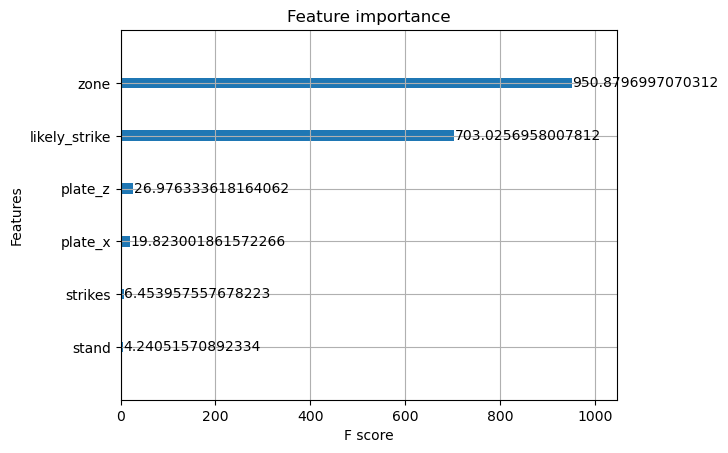

In [30]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

# Offspeed Model 

In [31]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

In [32]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [33]:

len(x2)

152322

In [34]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [35]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [36]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [37]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [38]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [39]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-11-01 22:12:31,877] A new study created in memory with name: no-name-1535ca00-f0de-4c36-b2e4-f373db41b940
[I 2023-11-01 22:12:32,123] Trial 0 finished with value: 0.9306745445593304 and parameters: {'max_depth': 6, 'eta': 0.06729579444010415, 'subsample': 0.6468778159986307, 'colsample_bytree': 0.8104356133024826}. Best is trial 0 with value: 0.9306745445593304.
[I 2023-11-01 22:12:32,336] Trial 1 finished with value: 0.9307730182176268 and parameters: {'max_depth': 9, 'eta': 0.07415332002965493, 'subsample': 0.7601516824812331, 'colsample_bytree': 0.5098522181803653}. Best is trial 1 with value: 0.9307730182176268.
[I 2023-11-01 22:12:32,517] Trial 2 finished with value: 0.9261775808304612 and parameters: {'max_depth': 3, 'eta': 0.052867317884432614, 'subsample': 0.8763193681827955, 'colsample_bytree': 0.928534645337492}. Best is trial 1 with value: 0.9307730182176268.
[I 2023-11-01 22:12:32,719] Trial 3 finished with value: 0.9394715247004759 and parameters: {'max_depth': 7, 

In [40]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9407845068110947
Best hyperparameters: {'max_depth': 9, 'eta': 0.29957296960433477, 'subsample': 0.7940029661592294, 'colsample_bytree': 0.9323986657824042}


In [41]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [42]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9402921385196127
Log Loss: 0.15322761565553691


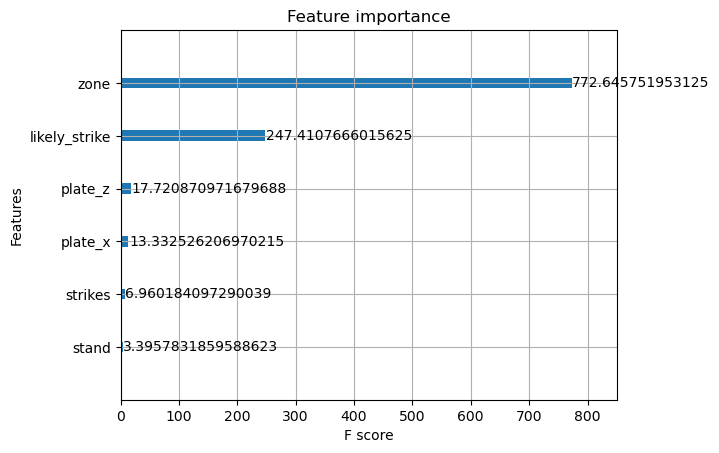

In [43]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [44]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [45]:

# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [46]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [47]:

# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -1 + complete.loc[condition2, 'prediction']


C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_26164\3171989487.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.03244156 0.23146641 0.0354445  ... 0.03036588 0.03036588 0.13373393]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']


In [48]:
len(condition2)

362561

In [50]:
players = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/players_query.csv")

In [51]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [52]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [53]:
strike_probs.head()

,half_inning,Unnamed: 1,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,deltaRE,is_strike,pitch_type_dict,likely_strike,prediction,probability_added,Unnamed: 0,mlb_id,mlb_name,team_name
0,716352_1_Bot,11,SI,2023-10-01,92.0,-2.78,5.68,"King, Michael",672580,650633,...,-0.038179,1,1.0,1,0.967558,0.032442,4412,669224,Austin Wells,yankees
1,716352_1_Bot,8,SI,2023-10-01,93.5,-2.60,5.68,"King, Michael",677951,650633,...,-0.028510,1,1.0,0,0.768534,0.231466,4412,669224,Austin Wells,yankees
2,716352_1_Bot,7,SI,2023-10-01,94.0,-2.59,5.74,"King, Michael",677951,650633,...,0.020254,0,1.0,0,0.026395,-0.973605,4412,669224,Austin Wells,yankees
3,716352_1_Bot,3,SI,2023-10-01,93.9,-2.62,5.54,"King, Michael",521692,650633,...,-0.016909,1,1.0,1,0.964556,0.035444,4412,669224,Austin Wells,yankees
4,716352_1_Bot,2,FF,2023-10-01,95.8,-2.24,5.97,"King, Michael",521692,650633,...,-0.017354,1,1.0,1,0.835639,0.164361,4412,669224,Austin Wells,yankees


### Catcher Evaluation

In [54]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Mark Kolozsvary               -11.871180
Henry Davis                   -12.058698
Chris Okey                    -30.386621
Tres Barrera                  -33.953463
Zack Collins                  -74.741246
Manny Pina                    -74.810691
Caleb Hamilton                -83.932013
Luis Torrens                  -88.294181
Michael Perez                 -91.760805
Tyler Cropley                -115.374480
Meibrys Viloria              -120.043195
Roberto Perez                -143.404151
Sam Huff                     -160.753594
Anthony Bemboom              -169.237915
Chadwick Tromp               -187.564151
Brian OKeefe                 -189.630818
Cesar Salazar                -202.865933
Jorge Alfaro                 -227.471267
Brian Serven                 -291.020314
MJ Melendez                  -313.171634
Drew Millas                  -377.929555
Logan Porter                 -398.571904
Ivan Herrera    

In [55]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [56]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Henry Davis               -0.559694
Mark Kolozsvary           -1.193204
Chris Okey                -1.489442
Tres Barrera              -2.042449
Caleb Hamilton            -3.902482
Zack Collins              -4.696620
Michael Perez             -4.790408
Luis Torrens              -5.129664
Manny Pina                -5.484625
Roberto Perez             -6.488964
Tyler Cropley             -6.623550
Anthony Bemboom           -6.830811
Meibrys Viloria           -7.061754
Brian OKeefe              -7.348789
Sam Huff                  -8.034252
Cesar Salazar             -8.969680
Chadwick Tromp            -9.860855
Jorge Alfaro             -12.799567
Brian Serven             -15.948715
MJ Melendez              -16.773940
Ivan Herrera             -21.325729
Drew Millas              -24.643048
Logan Porter             -24.712937
Sandy Leon               -25.613567
Tyler Heineman           -26.683849
David Fry                -33

In [57]:
framing = strike_probs.loc[((strike_probs['prediction'] >= .5) & (strike_probs['is_strike'] == 0)) | ((strike_probs['prediction'] <= .65) & (strike_probs['is_strike'] == 1))].copy()

In [58]:
framing.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

### Get out meaningless strikes that have nothing to do with framing

In [59]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = framing.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
William Contreras         22.235754
Jonah Heim                21.515888
Francisco Alvarez         21.030955
Cal Raleigh               20.196220
Patrick Bailey            19.348017
Austin Hedges             18.538778
Will Smith                18.302626
Kyle Higashioka           17.793892
Alejandro Kirk            16.988161
Christian Vazquez         15.682081
Elias Diaz                15.630233
Adley Rutschman           15.328848
J.T. Realmuto             15.172014
Jake Rogers               14.941972
Nick Fortes               14.845333
Sean Murphy               14.473781
Shea Langeliers           14.356285
Keibert Ruiz              14.280143
Yasmani Grandal           13.908779
Connor Wong               13.322440
Martin Maldonado          13.113764
Willson Contreras         12.662038
Gabriel Moreno            12.650900
Victor Caratini           12.491456
Yan Gomes                 12.036861
Travis dArnaud            11

###  I think that this is the best leaderboard. Filters out the gimme pitches

In [60]:
data = pb.statcast(start_dt='2023-10-27', end_dt='2023-11-1')

This is a large query, it may take a moment to complete


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]
C:\Users\clayton.thompson\AppData\Roaming\Python\Python311\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [61]:
data.game_pk.unique()

<IntegerArray>
[748535, 748540, 748541, 748542]
Length: 4, dtype: Int64

In [62]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
207,SL,2023-10-31,83.3,-1.66,5.85,"Leclerc, José",572233,600917,field_out,hit_into_play,...,11,11,7,7,11,Strategic,Standard,67,-0.004,-0.202
217,FF,2023-10-31,96.6,-1.34,6.15,"Leclerc, José",572233,600917,NaN,ball,...,11,11,7,7,11,Strategic,Standard,198,0.0,0.028
221,FF,2023-10-31,94.6,-1.12,6.13,"Leclerc, José",572233,600917,NaN,ball,...,11,11,7,7,11,Strategic,Standard,200,0.0,0.017
234,SL,2023-10-31,83.7,-1.86,5.82,"Leclerc, José",572233,600917,NaN,foul,...,11,11,7,7,11,Strategic,Standard,87,0.0,-0.046
252,SL,2023-10-31,85.0,-1.78,5.86,"Leclerc, José",572233,600917,NaN,swinging_strike,...,11,11,7,7,11,Strategic,Standard,102,0.0,-0.038


In [ ]:
data = data.loc[(data['description'] == 'called_strike') | (data['description'] == 'ball')].copy() # only called strikes and balls

In [ ]:
data['pitch_type_dict'] = data['pitch_type'].map(pitch_type_dict)
data['likely_strike'] = ((data['plate_x'].abs() <= .708) &
                            (data['plate_z'] <= data['sz_top']) &
                            (data['plate_z'] >= data['sz_bot'])).astype(int)
data['is_strike'] = data['description'].map({'called_strike': 1, 'ball': 0}) # convert to binary
data['p_throws'] = data['p_throws'].map({'R': 1, 'L': 0}) # convert to binary
data['stand'] = data['stand'].map({'R': 1, 'L': 0}) # convert to binary

In [ ]:
heaters_2023 = data[data['pitch_type_dict'] == 1].copy()
offspeed_2023 = data[data['pitch_type_dict'] == 2].copy()
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)

In [ ]:
complete['probability_added'] = 0.0
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1.0 - complete.loc[condition1, 'prediction']

condition2 = (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = 0.0 - complete.loc[condition2, 'prediction']

In [ ]:
# Apply the condition to create a new 'deltaRE' column
complete['deltaRE'] = np.where(complete['is_strike'] == 1, 
                               -0.05262950187221891, 
                               0.04634995015788309)

In [ ]:
cp = complete.loc[complete['probability_added'] != 0].copy()
cp['framing_runs'] = (cp['deltaRE'] * -1) * cp['probability_added'].abs()

In [ ]:
cp.to_csv('world_series_2023.csv')